# NeuroData Design: Sprint 1, Week 8
##### Patrick Myers, Wednesday Oct 23

This week I focused on getting caught up with the clustering team since I have been focusing on the phenotypic data for the past few weeks. My main goal was to see if our current feature matrix could generate clusters based with any correlation to the diagnostic data per patient.
##### Summary of Results:
* K-hop locality does not do an adequate job at discriminating diagnosis among JHU atlas subjects

I first changed the way that the edgelists were loaded since I was previously using a colab module. This can now be run as a jupyter notebook directly from github.

In [4]:
#Import the data from a Drive folder
import sys
import glob
import pandas as pd
import numpy as np
import subprocess
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches



filelist = []
file_list = glob.glob('../edgelists/*')
for f in file_list:
    file = open(f, 'r')
    filelist.append(file.read())

    
file_list = [f.replace("../edgelists\\", "") for f in file_list if "sub-" in f]
#file_list = [f.replace("sub-", "").replace("_acq-64dir_dwi_JHU.edgelist", "") for f in file_list if "sub-" in f]

 
sub_names = list()
for f in file_list:
    f = f.replace("sub-", "").replace("_acq-64dir_dwi_JHU.edgelist", "")
    sub_names.append(f)




Loading in the functions from Vivek to generate the feature matrix on the HBN data

In [5]:
#Define Vivek's functions to calculate eigenvalues of laplacian
import numpy as np

import subprocess
import requests

# Data structure
import networkx as nx
from networkx import normalized_laplacian_matrix


def _calculate_eigenvalues(G):
    # Return eigenvalues of the Laplacian
    L = normalized_laplacian_matrix(G)
    e = list(np.linalg.eigvals(L.A))
    return e
  
def feature_select(edgelists, files):
    
    # Get generator
    #edgelists = graph_collector.convert_edgelist_all()

    # Calculate eigenvalues for each graph
    eigvals = [_calculate_eigenvalues(G[0]) for G in edgelists]
    filelist = [_calculate_eigenvalues(G[1]) for G in edgelists]
    len_eig = [len(row) for row in eigvals]
    cutoff = len_eig[np.argmax(np.bincount(len_eig))]
    # Preserve only the necessary features
    X = []
    included_files = []
    count = 0
    for row in eigvals:
        if len(row) >= cutoff:
            X.append(row[-cutoff:])
            included_files.append(files[count])
        count = count + 1

    return X, included_files
  
def convert_edgelist(filename, file_name, draw_graph=False):

        # Fetch edgelist
        edges = filename.split()
        edges = [int(x) for x in edges]
        edges = [tuple(edges[x:x + 3]) for x in range(0, len(edges), 3)]

        #Removed all subject identifiers from printing so it can be put publicly
        if edges == []:
            print('' + ' is empty.')
            return

        # Convert edgelist to networkx object
        G = nx.Graph()
        G.add_weighted_edges_from(edges)

        if draw_graph:
            nx.draw(G)
            plt.show()

        return G, file_name

def convert_edgelist_all(filelist, file_list):
        # returns a generator of all filelists
        for fn in range(0,len(filelist)):
            G = convert_edgelist(filelist[fn], file_list[fn])
            if G is not None:
                yield G

In [6]:
def khop_locality(G, filename):

    subject_id = filename.split('_')[0].split('-')[1]
    embed = [subject_id]

    for node in G.nodes:

        one_hop = list(nx.single_source_shortest_path_length(G, node, cutoff=1).keys())
        two_hop = list(nx.single_source_shortest_path_length(G, node, cutoff=2).keys())

        embed += len(G.subgraph(one_hop).edges()), len(G.subgraph(two_hop).edges())

    if len(embed) == 97:
        return embed

First I load I convert all the edgelist files to graphs and compute the K-hop locality for each graph. I keep track of the file that each calculation is made on to later associate with a diagnosis.

In [7]:
#Perform PCA to get the first and second principal components
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt



edgelists = convert_edgelist_all(filelist, file_list)
files = []
for G in edgelists:
    files.append(G[1])
edgelists = convert_edgelist_all(filelist, file_list)
#data = feature_select(edgelists, files)
M = []
included_files = []
count = 0
for f in filelist:
    try:
        G, filename = convert_edgelist(f, file_list[count])
    except TypeError:
        print('')
    if G is not None:
        embed = khop_locality(G, file_list[count])
    if embed is not None:
        M.append(embed)
        included_files.append(file_list[count])
    count = count + 1
    

tags = []
for t in included_files:
    t = t.replace("sub-", "").replace("_acq-64dir_dwi_JHU.edgelist", "")
    tags.append(t)
X = M
X = np.asarray(X)


 is empty.
 is empty.



I remove the identifier to compute statistics on this feature matrix

In [8]:
Xnew = X[:,1:]

Xnew = Xnew.astype(dtype=int)

Plot the variance of each of the 96 features in order to figure out the appropriate threshold. I attempted all combinations of the top six variance features with no good outcome. The three highest variance features are plotted here as reference.

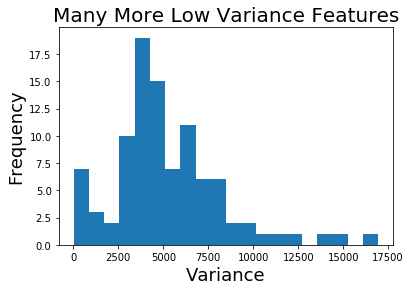

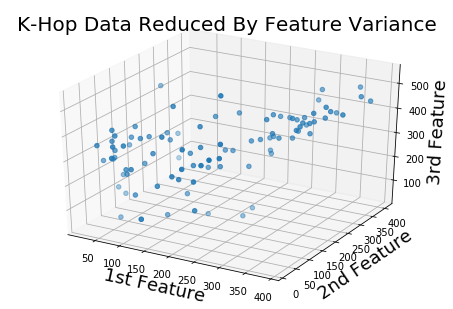

In [16]:
#Pick the top three variance features from feature matrix
from sklearn.feature_selection import VarianceThreshold
from scipy import ndimage
from mpl_toolkits.mplot3d import Axes3D
var = []
for i in range(0,Xnew.shape[1]):
    var.append(ndimage.variance(Xnew[:,i]))
var = np.asarray(var)
plt.hist(var, 20)
plt.title('Many More Low Variance Features', fontsize = 20)
plt.xlabel('Variance', fontsize=18)
plt.ylabel('Frequency', fontsize = 18)
plt.show()

rem = VarianceThreshold(threshold=10000)
reduced = rem.fit_transform(Xnew)
reduced.shape


#Plot data on these  features
fig = plt.figure(facecolor = 'w')
ax = Axes3D(fig)
ax.scatter(reduced[:,0],reduced[:,1],reduced[:,2]);
plt.xlabel('1st Feature', fontsize=18)
plt.ylabel('2nd Feature', fontsize=18)
ax.set_zlabel('3rd Feature', fontsize=18)
ax.set_facecolor('white')
fig.suptitle('K-Hop Data Reduced By Feature Variance', fontsize=20)
plt.show()

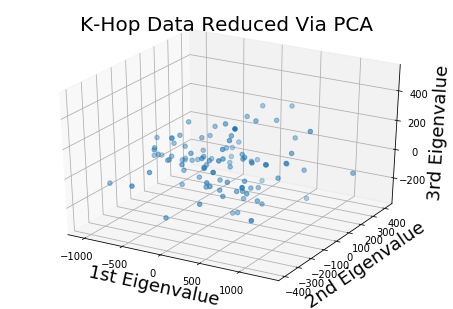

In [17]:
pca = PCA(n_components=3)
projected = pca.fit_transform(Xnew)

fig = plt.figure(facecolor = 'w')
ax = Axes3D(fig)
ax.scatter(projected[:,0],projected[:,1], projected[:,2]);
plt.xlabel('1st Eigenvalue', fontsize=18)
plt.ylabel('2nd Eigenvalue', fontsize=18)
ax.set_zlabel('3rd Eigenvalue', fontsize=18)
ax.set_facecolor('white')
fig.suptitle('K-Hop Data Reduced Via PCA', fontsize=20)
plt.show()

Match each of the data points to a diagnosis for a subject. Each diagnosis within the dataset is a different color in the scatter plot. Visually, there is no pattern or clusters between diagnoses.

(100, 3)


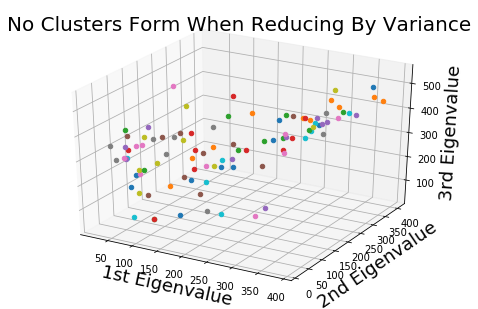

In [14]:
import pandas as pd
import numpy as np
import difflib


diagnoses = pd.read_csv('../processed/Diagnoses.csv')
print(diagnoses.shape)


for i in range(0, 100):
  diagnoses.iloc[i,0] = diagnoses.iloc[i,0].rstrip()

for i in range(0,97):
  tags[i] = tags[i].rstrip()

sub_names = list()
for f in file_list:
    f = f.replace("sub-", "").replace("_acq-64dir_dwi_JHU.edgelist", "")
    sub_names.append(f)


labels = np.zeros((98,3), dtype=object)
for i in range(0,98):
    labels[i,0] = sub_names[i]
    labels[i,1] = tags[i]
    labels[i,2] = str(sub_names[i] == tags[i])
label_check = pd.DataFrame(data = labels, columns = ['Labels in Plot', 'Actual Labels', 'Same'])
label_check.to_csv('../processed/label_check.csv')


fig = plt.figure(facecolor = 'w')
ax = Axes3D(fig)
plt.xlabel('1st Eigenvalue', fontsize=18)
plt.ylabel('2nd Eigenvalue', fontsize=18)
ax.set_zlabel('3rd Eigenvalue', fontsize=18)
fig.suptitle('No Clusters Form When Reducing By Variance', fontsize=20)
for x in range(0, len(tags)):
  for i in range(0, diagnoses.shape[0]):
    if tags[x] == diagnoses.iloc[i,0]:
      if diagnoses.iloc[i,1] == 'No Diagnosis Given' or diagnoses.iloc[i,1] == 'No Diagnosis Given: Incomplete Eval':
        ax.scatter(reduced[x,0],reduced[x,1],reduced[x,2]);#, c='k');
      elif diagnoses.iloc[i,1] == 'Neurodevelopmental Disorders':
        ax.scatter(reduced[x,0],reduced[x,1],reduced[x,2]);#, c='r');
      elif diagnoses.iloc[i,1] == 'Depressive Disorders':
        ax.scatter(reduced[x,0],reduced[x,1],reduced[x,2]);#, c='b');
      elif diagnoses.iloc[i,1] == 'Anxiety Disorders':
        ax.scatter(reduced[x,0],reduced[x,1],reduced[x,2]);#, c='y');
      elif diagnoses.iloc[i,1] == 'Bipolar and Related Disorders':
        ax.scatter(reduced[x,0],reduced[x,1],reduced[x,2]);#, c='g');
      elif diagnoses.iloc[i,1] == 'Disruptive, Impulse Control and Conduct Disorders':
        ax.scatter(reduced[x,0],reduced[x,1],reduced[x,2]);#, c='c');
      else:
        ax.scatter(reduced[x,0],reduced[x,1],reduced[x,2]);#, c='p');
        

plt.show()

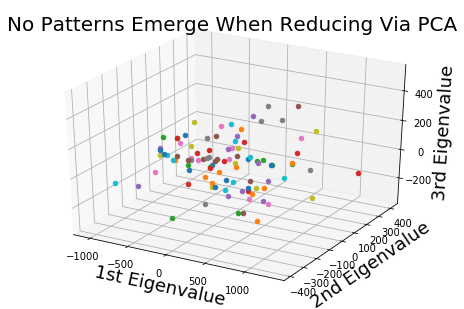

In [15]:
fig = plt.figure(facecolor = 'w')
ax = Axes3D(fig)
plt.xlabel('1st Eigenvalue', fontsize=18)
plt.ylabel('2nd Eigenvalue', fontsize=18)
ax.set_zlabel('3rd Eigenvalue', fontsize=18)
fig.suptitle('No Patterns Emerge When Reducing Via PCA', fontsize=20)
for x in range(0, len(tags)):
  for i in range(0, diagnoses.shape[0]):
    if tags[x] == diagnoses.iloc[i,0]:
      if diagnoses.iloc[i,1] == 'No Diagnosis Given' or diagnoses.iloc[i,1] == 'No Diagnosis Given: Incomplete Eval':
        ax.scatter(projected[x,0],projected[x,1],projected[x,2]);#, c='k');
      elif diagnoses.iloc[i,1] == 'Neurodevelopmental Disorders':
        ax.scatter(projected[x,0],projected[x,1],projected[x,2]);#, c='r');
      elif diagnoses.iloc[i,1] == 'Depressive Disorders':
        ax.scatter(projected[x,0],projected[x,1],projected[x,2]);#, c='b');
      elif diagnoses.iloc[i,1] == 'Anxiety Disorders':
        ax.scatter(projected[x,0],projected[x,1],projected[x,2]);#, c='y');
      elif diagnoses.iloc[i,1] == 'Bipolar and Related Disorders':
        ax.scatter(projected[x,0],projected[x,1],projected[x,2]);#, c='g');
      elif diagnoses.iloc[i,1] == 'Disruptive, Impulse Control and Conduct Disorders':
        ax.scatter(projected[x,0],projected[x,1],projected[x,2]);#, c='c');
      else:
        ax.scatter(projected[x,0],projected[x,1],projected[x,2]);#, c='p');
        

plt.show()